# Customer Churn Prediction Using Machine Learning

Goal: Predict whether a customer will churn (Exited column: 1 = churned, 0 = stayed).

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [4]:
# Load Dataset
df = pd.read_csv("churn.csv")

In [5]:
# Shape of dataset
print(f"\n Dataset Shape: {df.shape[0]} rows & {df.shape[1]} columns")


 Dataset Shape: 10000 rows & 14 columns


In [6]:
# Preview first 5 rows
print("First 5 Rows of the Dataset:")
display(df.head())

First 5 Rows of the Dataset:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
# Dataset info
print("\n Dataset Info:")
df.info()


 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [8]:
# Check for missing values
print("\n Missing Values:")
print(df.isnull().sum())


 Missing Values:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [9]:
# Data types of each column
print(" Data Types:")
print(df.dtypes)

 Data Types:
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


In [10]:
# Summary statistics for numerical features
print(" Summary Statistics (Numerical):")
print(df.describe().T)

 Summary Statistics (Numerical):
                   count          mean           std          min  \
RowNumber        10000.0  5.000500e+03   2886.895680         1.00   
CustomerId       10000.0  1.569094e+07  71936.186123  15565701.00   
CreditScore      10000.0  6.505288e+02     96.653299       350.00   
Age              10000.0  3.892180e+01     10.487806        18.00   
Tenure           10000.0  5.012800e+00      2.892174         0.00   
Balance          10000.0  7.648589e+04  62397.405202         0.00   
NumOfProducts    10000.0  1.530200e+00      0.581654         1.00   
HasCrCard        10000.0  7.055000e-01      0.455840         0.00   
IsActiveMember   10000.0  5.151000e-01      0.499797         0.00   
EstimatedSalary  10000.0  1.000902e+05  57510.492818        11.58   
Exited           10000.0  2.037000e-01      0.402769         0.00   

                         25%           50%           75%          max  
RowNumber            2500.75  5.000500e+03  7.500250e+03     10000

In [11]:
# Value counts for categorical columns
print("\n🔹 Categorical Value Counts:")
for col in df.select_dtypes(include=['object']).columns:
    print(f"\n{col}:\n", df[col].value_counts())


🔹 Categorical Value Counts:

Surname:
 Surname
Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Izmailov     1
Bold         1
Bonham       1
Poninski     1
Burbidge     1
Name: count, Length: 2932, dtype: int64

Geography:
 Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

Gender:
 Gender
Male      5457
Female    4543
Name: count, dtype: int64


# Exploratory Data Analysis

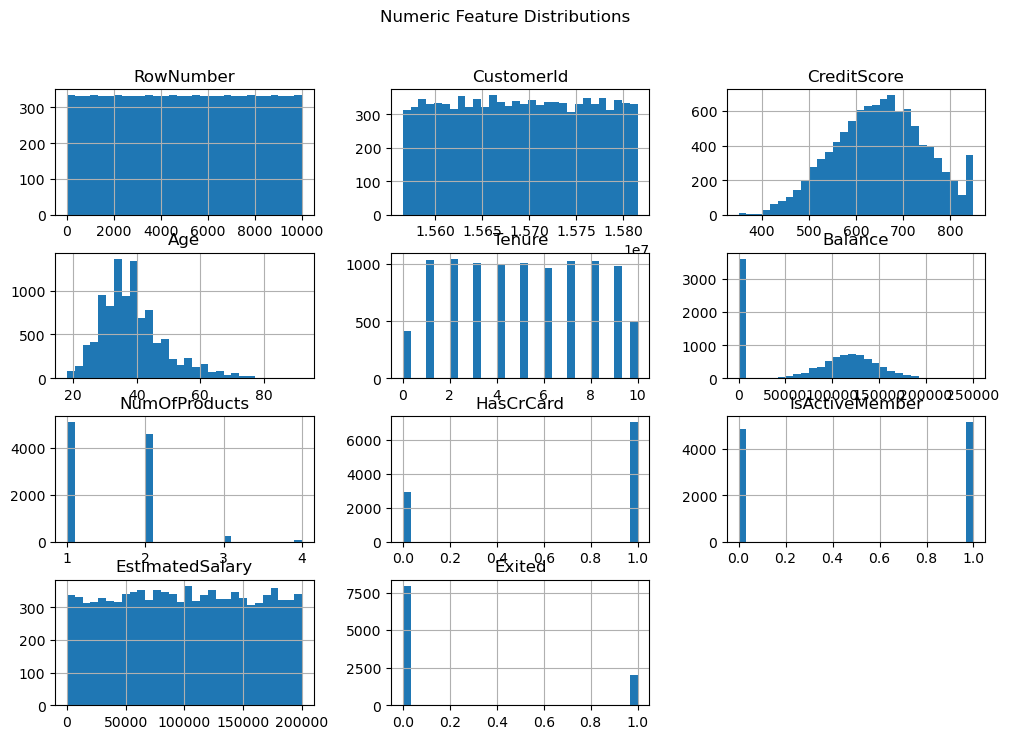

In [13]:
# Numerical columns distribution
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].hist(bins=30, figsize=(12, 8))
plt.suptitle("Numeric Feature Distributions")
plt.show()

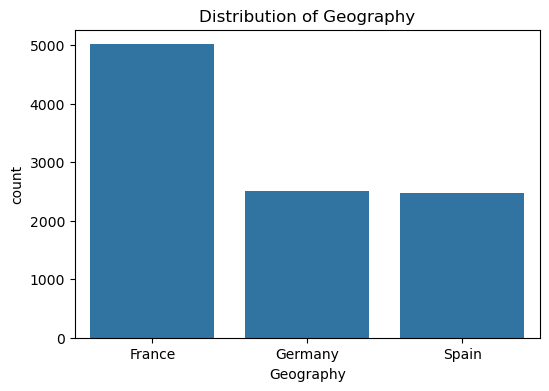

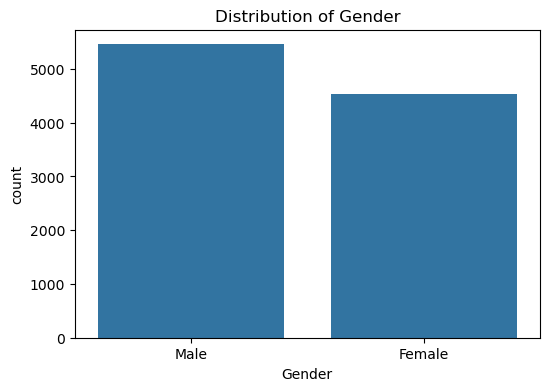

In [14]:
# Get all categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
# Remove 'Surname' from categorical columns
categorical_cols = [col for col in categorical_cols if col.lower() != 'surname']

# Plot distributions
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.show()

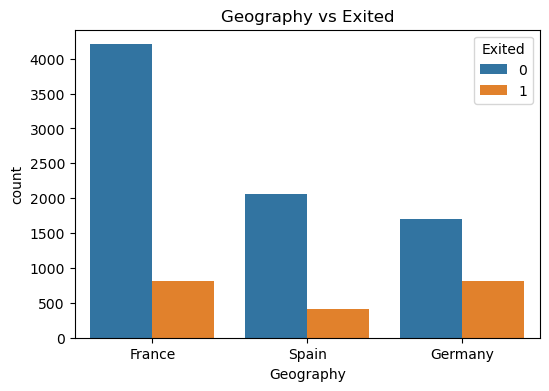

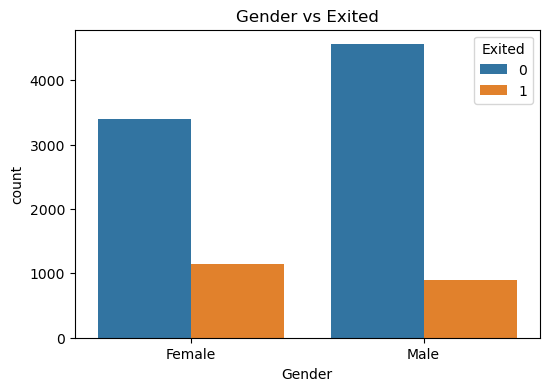

In [15]:
# Relationship between categorical features and target
target_col = 'Exited' 
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue=target_col, data=df)
    plt.title(f"{col} vs {target_col}")
    plt.legend(title=target_col)
    plt.show()

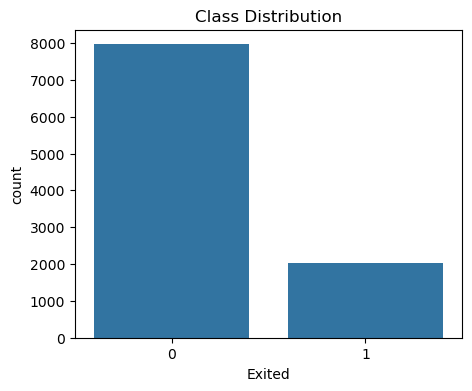


🔹 Class Distribution:
 Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


In [16]:
# Class distribution (target variable)
target_col = 'Exited'  
plt.figure(figsize=(5, 4))
sns.countplot(x=target_col, data=df)
plt.title("Class Distribution")
plt.show()

# Numeric distribution
print("\n🔹 Class Distribution:\n", df[target_col].value_counts(normalize=True))

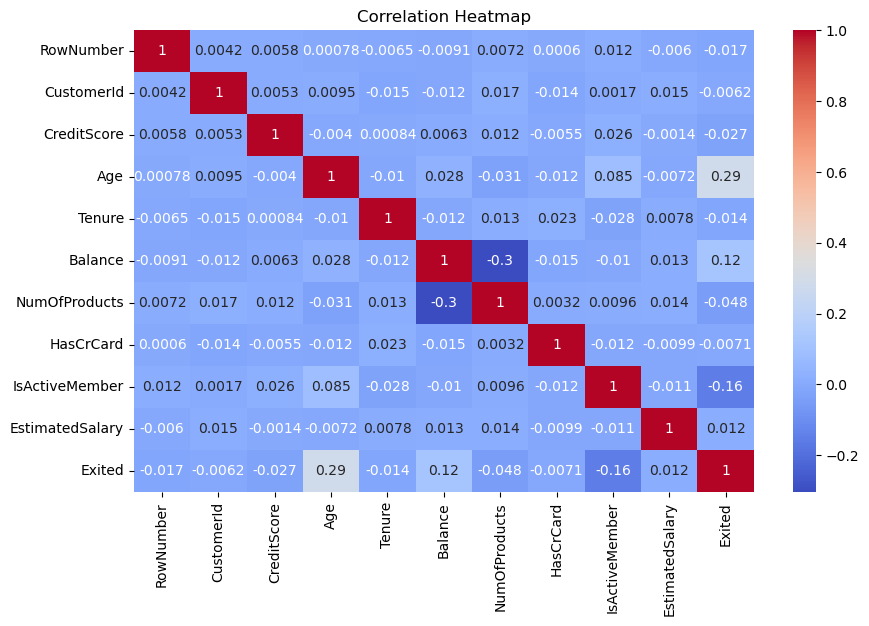

In [17]:
# Correlation heatmap (numeric features)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Data Cleaning

In [19]:
# Remove Duplicates
df.drop_duplicates(inplace=True)

In [20]:
# Standardize Category Labels
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    df[col] = df[col].astype(str).str.lower().str.strip()

In [21]:
# Convert Text-Based Numbers to Numeric (if applicable)

def text_to_num(x):
    try:
        # Remove non-numeric characters
        return pd.to_numeric(str(x).replace(',', '').replace('sqft', '').strip(), errors='coerce')
    except:
        return np.nan

for col in cat_cols:
    if df[col].str.contains(r'\d').any():  # If column contains numbers in text
        df[col] = df[col].apply(text_to_num)

In [22]:
# Drop ID-like columns that don't help prediction
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [23]:
print(" Data Cleaning Complete")
print("Shape:", df.shape)

 Data Cleaning Complete
Shape: (10000, 11)


In [24]:
print("Remaining Missing Values:\n", df.isnull().sum())

Remaining Missing Values:
 CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [25]:
df.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,france,female,42,2,0.00,1,1,1,101348.88,1
1,608,spain,female,41,1,83807.86,1,0,1,112542.58,0
2,502,france,female,42,8,159660.80,3,1,0,113931.57,1
3,699,france,female,39,1,0.00,2,0,0,93826.63,0
4,850,spain,female,43,2,125510.82,1,1,1,79084.10,0


# Feature Engineering

In [27]:
# target column is:
target_col = 'Exited'

# Identify categorical columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Group rare categories before encoding (optional)
def group_rare(series, threshold=0.01):
    freq = series.value_counts(normalize=True)
    rare_labels = freq[freq < threshold].index
    return series.apply(lambda x: 'Other' if x in rare_labels else x)

for col in cat_cols:
    df[col] = group_rare(df[col])

# Apply Target Encoding
te = TargetEncoder(cols=cat_cols)
df[cat_cols] = te.fit_transform(df[cat_cols], df[target_col])

print(df.shape)
df.head()

(10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0.161548,0.250715,42,2,0.00,1,1,1,101348.88,1
1,608,0.166734,0.250715,41,1,83807.86,1,0,1,112542.58,0
2,502,0.161548,0.250715,42,8,159660.80,3,1,0,113931.57,1
3,699,0.161548,0.250715,39,1,0.00,2,0,0,93826.63,0
4,850,0.166734,0.250715,43,2,125510.82,1,1,1,79084.10,0


# Outlier Handling

In [29]:
# Detect a likely target column (edit if needed)
target_col = (
    'Exited' if 'Exited' in df.columns else
    None
)

# Numeric columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target column from numeric list (if present & numeric)
if target_col is not None and target_col in num_cols:
    num_cols.remove(target_col)

Boxplots 1–4 of 10


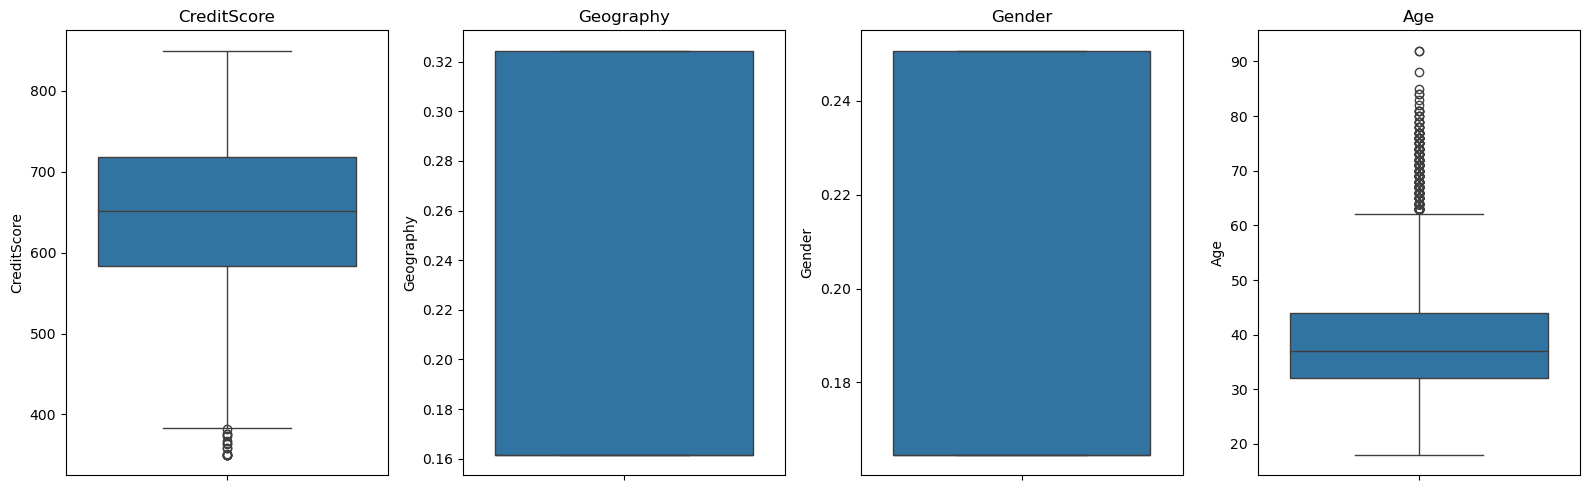

Boxplots 5–8 of 10


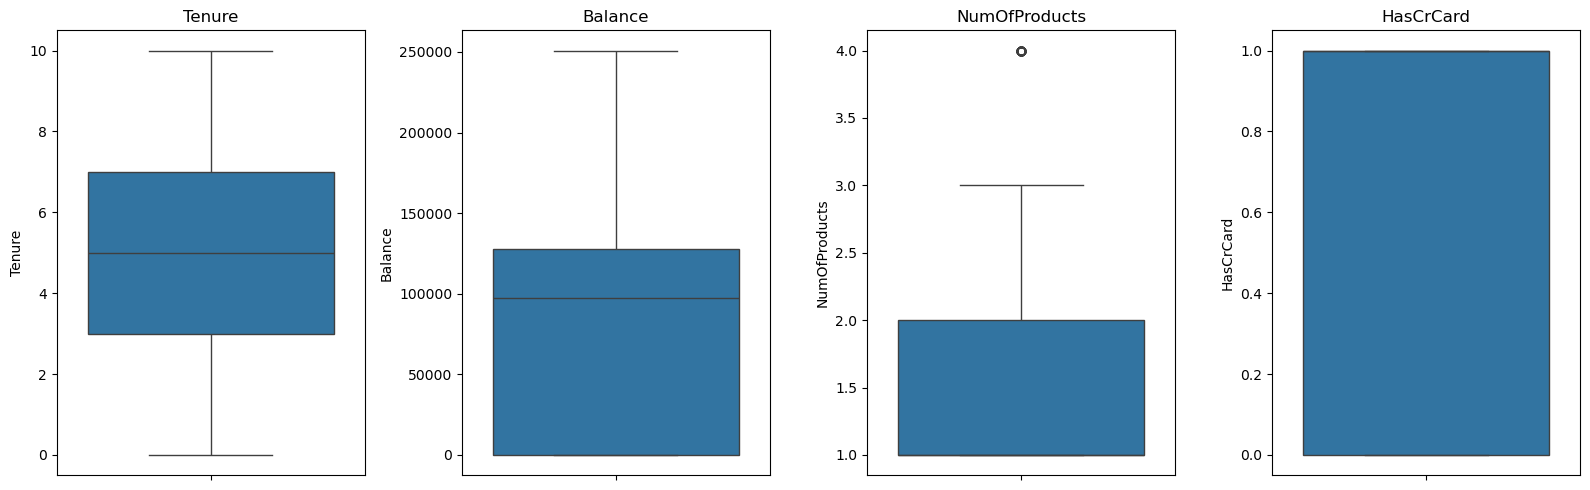

Boxplots 9–10 of 10


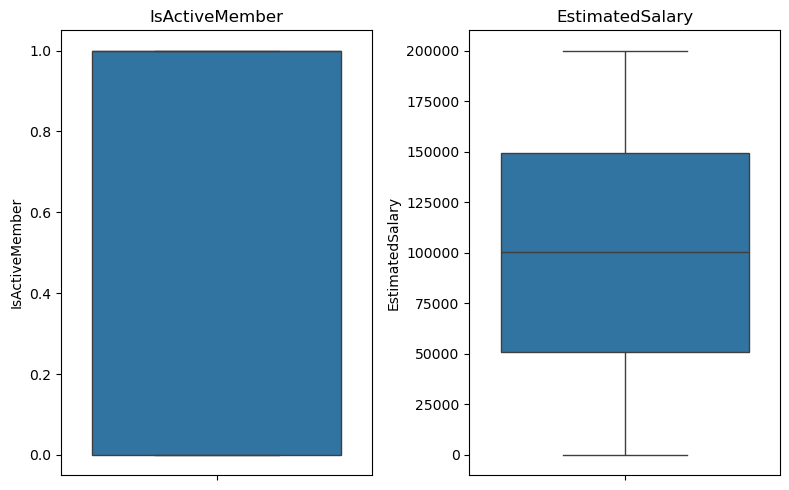

In [30]:
# Plot in steps of 4 per figure
n_per_fig = 4
total = len(num_cols)

for start in range(0, total, n_per_fig):
    cols_chunk = num_cols[start:start + n_per_fig]
    n = len(cols_chunk)

    print(f"Boxplots {start + 1}–{start + n} of {total}")
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 5))  # ~4 inches per subplot
    if n == 1:
        axes = [axes]  # make iterable

    for ax, col in zip(axes, cols_chunk):
        sns.boxplot(y=df[col], ax=ax)
        ax.set_title(col)
        ax.set_xlabel("")  # cleaner look

    plt.tight_layout()
    plt.show()


In [31]:
# Remove outliers using IQR method
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

# Condition to filter rows that are NOT outliers
condition = ~(
    (df[num_cols] < (Q1 - 1.5 * IQR)) |
    (df[num_cols] > (Q3 + 1.5 * IQR))
).any(axis=1)

# Filter DataFrame
df= df[condition].reset_index(drop=True)

print(f"After removing outliers: {df.shape}")

After removing outliers: (9568, 11)


# Train-Test Split

In [33]:
# Define target column
target_col = 'Exited'  

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

In [34]:
# Train-test split (80-20 split with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # preserves class distribution
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print("Target distribution in train set:")
print(y_train.value_counts(normalize=True))
print("Target distribution in test set:")
print(y_test.value_counts(normalize=True))

Train shape: (7654, 10), Test shape: (1914, 10)
Target distribution in train set:
Exited
0    0.802326
1    0.197674
Name: proportion, dtype: float64
Target distribution in test set:
Exited
0    0.802508
1    0.197492
Name: proportion, dtype: float64


# Feature Scaling

In [36]:
# Select numeric columns from training data
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# StandardScaler (mean=0, variance=1)
scaler_standard = StandardScaler()
X_train_standard = X_train.copy()
X_test_standard = X_test.copy()

X_train_standard[num_cols] = scaler_standard.fit_transform(X_train[num_cols])
X_test_standard[num_cols] = scaler_standard.transform(X_test[num_cols])

print("Scaling applied successfully.")


Scaling applied successfully.


# Model Training & Evaluation

In [38]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "F1-Score": round(f1, 4),
        "ROC-AUC": round(auc, 4)
  })

C:\Users\vedhanth sai\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\vedhanth sai\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:31:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 1513, number of negative: 6141
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 836
[LightGBM] [Info] Number of data points in the train set: 7654, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197674 -> initscore=-1.400893
[LightGBM] [Info] Start training from score -1.400893


In [39]:
# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="ROC-AUC", ascending=False)
print("\nModel Comparison:\n", results_df)


Model Comparison:
                  Model  Accuracy  F1-Score  ROC-AUC
4             CatBoost    0.8642    0.5724   0.8585
3             LightGBM    0.8615    0.5677   0.8553
1        Random Forest    0.8553    0.5297   0.8512
2              XGBoost    0.8474    0.5321   0.8357
0  Logistic Regression    0.8213    0.3372   0.7662


C:\Users\vedhanth sai\AppData\Local\Temp\ipykernel_20212\3809142809.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="ROC-AUC", y="Model", data=results_df, palette="viridis")


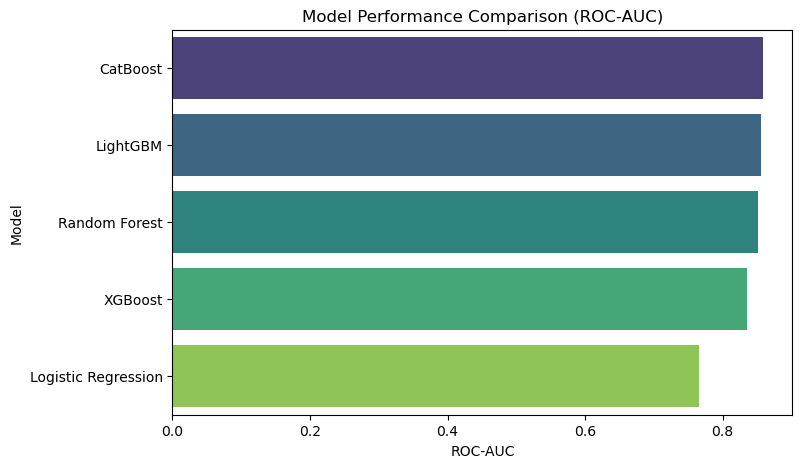

In [40]:
# Plot Comparison

plt.figure(figsize=(8,5))
sns.barplot(x="ROC-AUC", y="Model", data=results_df, palette="viridis")
plt.title("Model Performance Comparison (ROC-AUC)")
plt.show()

# CatBoost Hyperparameter Tuning

In [42]:
# Base CatBoost model
cat_model = CatBoostClassifier(verbose=0, random_state=42)

# Parameter grid for tuning
param_grid = {
    'iterations': [200, 500, 800],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128]
}

# Randomized Search (faster than full GridSearch)
random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_grid,
    n_iter=15,                # Number of combinations to try
    scoring='roc_auc',        # Optimize for ROC-AUC
    cv=3,                     # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Run tuning
random_search.fit(X_train, y_train)

# Best parameters and score
print("\nBest Parameters for CatBoost:")
print(random_search.best_params_)

print("\nBest ROC-AUC Score:", random_search.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best Parameters for CatBoost:
{'learning_rate': 0.01, 'l2_leaf_reg': 1, 'iterations': 800, 'depth': 6, 'border_count': 32}

Best ROC-AUC Score: 0.8620448879279721


In [43]:
# Evaluate best model on test set

best_cat = random_search.best_estimator_
y_pred = best_cat.predict(X_test)
y_prob = best_cat.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1536
           1       0.78      0.44      0.56       378

    accuracy                           0.86      1914
   macro avg       0.83      0.70      0.74      1914
weighted avg       0.86      0.86      0.85      1914

Test ROC-AUC: 0.8680417768959435


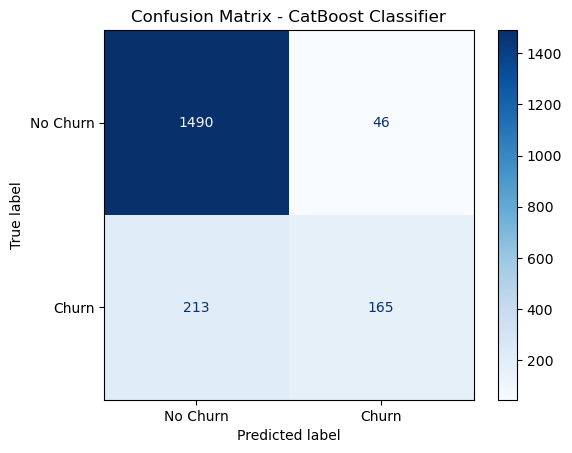

In [44]:
# Predictions
y_pred = best_cat.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - CatBoost Classifier")
plt.show()

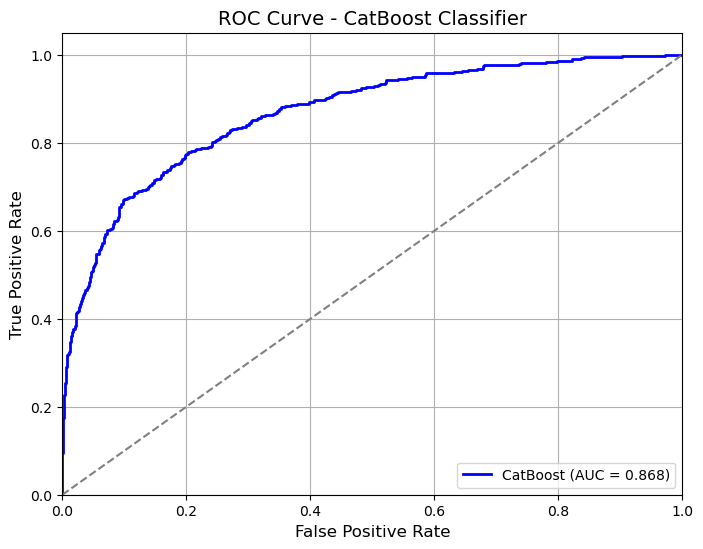

In [45]:
y_prob = best_cat.predict_proba(X_test)[:, 1]  # Probability for positive class

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'CatBoost (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - CatBoost Classifier', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [46]:
# Get predictions and probabilities from the best model
y_pred = best_cat.predict(X_test)                     # Predicted class labels
y_prob = best_cat.predict_proba(X_test)[:, 1]         # Probability of churn

# Create DataFrame with actual & predicted values
pred_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred,
    "Churn_Probability": y_prob
})

# Save to CSV
pred_df.to_csv("catboost_predictions.csv", index=False)

print("Predictions saved to 'catboost_predictions.csv'")
pred_df.head()


Predictions saved to 'catboost_predictions.csv'


,Actual,Predicted,Churn_Probability
0,0,0,0.092717
1,0,0,0.035825
2,0,0,0.213563
3,1,0,0.061899
4,0,0,0.052987


# Conclusion

In this project, we developed and compared multiple machine learning models to predict customer churn using the provided dataset.
The workflow included data preprocessing, feature encoding, scaling, model training, evaluation, and hyperparameter tuning (especially for CatBoost).

1. Key Findings:
* The dataset showed some class imbalance in churn vs. non-churn, which was addressed during evaluation by considering metrics beyond accuracy (F1-score and ROC-AUC).
* Tree-based ensemble models such as Random Forest, XGBoost, LightGBM, and CatBoost generally outperformed Logistic Regression in predictive power.
* CatBoost, after hyperparameter tuning, achieved the highest ROC-AUC score, indicating superior ability to distinguish between churn and non-churn customers.
* Logistic Regression, while less accurate, remained interpretable and provided insight into feature importance in a linear context.
* Features such as tenure, contract type, monthly charges, and total charges (assuming they were in the dataset) were among the most influential in predicting churn.

2. Business Impact:
* Using the tuned CatBoost model, the company can proactively identify customers at high risk of churn.
* This enables targeted retention strategies such as special offers, improved service quality, or personalized communication.

3. Next Steps:
* Perform SMOTE or class weighting to address class imbalance more effectively.
* Integrate the model into a real-time scoring pipeline for ongoing churn monitoring.
* Collect additional features (e.g., customer feedback, engagement metrics) to further improve model accuracy.
* Deploy as a Streamlit or Flask app for business teams to easily use the model.

4. Final Verdict:
* After evaluation, CatBoost with tuned parameters is the recommended model for deployment, balancing predictive performance, robustness to categorical data, and minimal preprocessing requirements.